# Assignment 3: Traveling Salesman Problem Using Simulated Annealing

In [1]:
from functools import wraps, reduce
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## 0. Functions

0.1 Set up a decorator function timeit to measure and print the execution time of a wrapped function. 

In [2]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

0.2 Set up a function that reads and parses the data from tsp files, and returns the list of city coordinates.

In [3]:
def read_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cities = []
    for line in lines:
        parts = line.split()
        if len(parts) == 3 and parts[0].isdigit():
            cities.append((float(parts[1]), float(parts[2])))

    return cities

0.3 Set up a function which normalises the list of city coordinates to 0-1 coordinates. 

In [4]:
def normalise_dist(cities):
    # lambda function to split the coordinates into separate lists, 'x_coord','y_coord' 
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    # get minmax values of both coordinates
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    # lambda functioon to normalize the coordinates with the range 
    normalizer = lambda minmax_x, x_coord: [(x - minmax_x[0]) / (minmax_x[1] - minmax_x[0]) for x in x_coord]
    # get normalized values of both coordinates 
    normalized_x = normalizer(minmax_x, x_coord)
    normalized_y = normalizer(minmax_y, y_coord)
    # lambda function to recouple normalized x and y coordinates for each city
    reconstructor = lambda a, b: (a, b)
    # final normalized list
    normalised = list(map(reconstructor, normalized_x, normalized_y))
    return normalised

0.4 Set up a function which reverses the normalization of the list of city coordinates from 0-1 coordinates back to the original values.

In [5]:
def denormalise_dist(cities, norm_coord):
    # lambda function to split the coordinates into separate lists, 'x_coord','y_coord' 
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    x_norm , y_norm = devider(norm_coord)
    # get minmax values of both coordinates
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    # lambda function to calculate the original coordinates
    denormalize = lambda minmax, norm_coords: [x * (minmax[1] - minmax[0]) + minmax[0] for x in norm_coords]
    denormalized_x = denormalize(minmax_x, x_norm)
    denormalized_y = denormalize(minmax_y, y_norm)
    # lambda function to recouple normadelized x and y coordinates for each city
    reconstructor = lambda a, b: (a, b)
    denormalised = list(map(reconstructor, denormalized_x, denormalized_y))
    return denormalised

0.5 Set up a function which calculates the total distance covered in a given tour of the cities.

In [6]:
def calculate_total_distance(tour, cities):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city2 = cities[tour[i + 1]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    # return to the starting city
    total_distance += math.sqrt((cities[tour[-1]][0] - cities[tour[0]][0])**2 +
                                (cities[tour[-1]][1] - cities[tour[0]][1])**2)

    return total_distance

0.6. Set up functions to ammend the tours 

0.6.1 Set up a function which "moves" a single city's position within a given tour from i to j  

In [8]:
def move_city(tour):
    i, j = random.sample(range(1, len(tour)-1), 2)
    city = tour.pop(i)
    tour.insert(j, city)
    return tour

0.6.2 Set up a function which "moves" a whole section of the tour to a new (random) position 

In [9]:
def move_part(route):
    i, j = sorted(random.sample(range(1, len(route)-1), 2))
    route_slice = route[i:j]
    del route[i:j]
    if len(route) - 1 > 0:
        new_position = random.randint(1, len(route) - 1)
    else:
        new_position = 1
    route[new_position:new_position] = route_slice
    return route

0.6.3 Set up a function to implement a 2-opt swap operation for a deterministic algorithm. The 2-opt swap is a local search heuristic that attempts to improve a given route by reversing a portion of it. 

In [10]:
def two_opt(tour):
    # apply 2-opt move
    i, j = random.sample(range(len(tour)), 2)
    i, j = sorted([i, j])
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

In [11]:
def two_opt_swap(route, i, j):
    new_route = route[:i] + route[i:j + 1][::-1] + route[j + 1:]
    return new_route

In [12]:
def optimise_with_2opt(route, cities):
    """The determenistic alg for 2-opt swap on best result."""
    improvement = True
    best_route = route
    best_distance = calculate_total_distance(route, cities)
    while improvement:
        improvement = False
        for i in range(1, len(best_route) - 1):
            for j in range(i + 1, len(best_route)):
                new_route = two_opt_swap(best_route, i, j)
                new_distance = calculate_total_distance(new_route, cities)
                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route
                    improvement = True
                    break
            if improvement:
                break

    return best_route

0.7 Set up the cooling schedule functions

0.7.1 Logarithmic cooling

In [13]:
def Hoffmann_Salamon_cooling(iter, D = 10):
        return (D-1)/math.log(iter + 2)

0.7.2 Exponential cooling

In [14]:
def exponential_cooling(temp, rate):
        return temp*rate

0.7.3 Fast cooling

In [15]:
def fast_cooling(iteatr, initial):
        return initial/(1+iteatr)

0.9. Set up functions to run versions of the simulated annealing method

0.9.1 Set up the function to run the simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule, taking into account 2-opt and move city optimizations ('tomc')

In [16]:
def simulated_annealing_tomc(cities, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    random.shuffle(current_tour)
    current_distance = calculate_total_distance(current_tour, cities)

    best_tour = current_tour[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(num_iterations):
        # Choose a random elementary edit
        if random.uniform(0, 1) < 0.5:
            new_tour = two_opt(current_tour)
        else:
            new_tour = move_city(current_tour)

        # Calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)

        # Decide whether to accept the new tour
        if new_distance < current_distance or random.uniform(0, 1) < math.exp((current_distance - new_distance) / temperature):
            current_tour = new_tour
            current_distance = new_distance

            # Update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        # Cool down the temperature
        temperature *= cooling_rate

    return best_tour, best_distance

0.9.2 Set up the function to run the default simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule

In [19]:
@timeit
def simulated_annealing(cities, initial_temperature, cooling_rate):

    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    
    """Outer loop for the cooling schedule"""
    for inner_ier in range(3000):
        
        a = [1,1,2,3,3,4]
        max_iterations = 2000

        """Inner loop (Markov Chain length)"""
        for iteration in range(max_iterations):
        
            new_tour = current_tour[:]
            u = random.sample(a, 1)
        
            if u[0] == 1:
            # 2opt swap
                tik = 1
                i, j = sorted(random.sample(range(1, num_cities), 2))
                new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
            elif u[0] == 2:
            # move city 
                tik = 2
                new_tour = move_city(new_tour)
            elif u[0] == 3:
            # move part
                tik = 3
                new_tour = move_part(new_tour)
            elif u[0] == 4:
                # reverse two adjacent neigbours
                tik = 4
                i, j = random.sample(range(1, num_cities), 2)
                tem = new_tour[i]
                try: 
                    new_tour[i] = new_tour[i+1]
                    new_tour[i+1] = tem
                except: 
                    new_tour[i] = new_tour[i-1]
                    new_tour[i-1] = tem
                
            # calculate the new tour distance
            new_distance = calculate_total_distance(new_tour, cities)
            delta_distance = new_distance - current_distance
        
            # decide whether to accept the new tour
            if delta_distance <= 0:
                fitnes.append(new_distance)
                fitnes_t.append((inner_ier)*max_iterations +iteration) 
                bb.append(best_distance)
                current_tour = new_tour
                current_distance = new_distance
                # update the best tour if needed
                if new_distance < best_distance:
                    best_tour = new_tour
                    best_distance = new_distance
                    print(best_distance)
                    no_progress =0
                else:
                    no_progress += 1
            else:
                no_progress += 1
                argument = -delta_distance / temperature
                random_u = random.uniform(0, 1)
                prob_array.append(math.exp(argument))
                t.append((inner_ier)*max_iterations +iteration) 
                if math.exp(argument) > random_u:
                    current_tour = new_tour
                    current_distance = new_distance

    
        temperature = exponential_cooling(temperature, cooling_rate)
        
        # reaneiling
        if temperature < 0.1 and no_progress > 50:
            best_route_2opt = optimise_with_2opt(best_tour, cities)
            best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
            if best_dist_2opt == best_distance:
                temperature = 3
                print("gg")
            
        temp_array.append(temperature)
        temp_t.append(inner_ier)                       
      
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

0.10 Set up a function to plot a given tour of the cities

In [20]:
def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

0.11 Set up a function to run multiple simulated_annealing simulations

In [21]:
def run_multiple_simulations(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

0.12 Set up a function to find the best hyperparameters for a given TSP

In [22]:
# too long to run, delete if not used
def param_search(cities, initial_temp, cooling_rate, in_temp=0.05, col_rate=0.95, max_no_improve=30):
    """ Simulated aneiling to find best hyperparameters for TSP"""
    curr_temp = initial_temp
    curr_rate = cooling_rate
    best_tour, best_distance_init, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, initial_temp, cooling_rate)
    
    temperature = in_temp
    best_abs = np.inf
    best_initial_temp = 0 
    best_cooling_rate = 0
    no_improve_counter = 0

    log = []

    for k in range(150):
        step_size_temp = 2.5 / (1 + k)  
        step_size_rate = 0.01 / (1 + k)  

        mean_len = []
        improved = False

        for i in range(4):
            u = random.uniform(-step_size_temp, step_size_temp) 
            new_temp = max(curr_temp + u, 0.1) 
            u = random.uniform(-step_size_rate, step_size_rate) 
            new_rate = min(max(curr_rate + u, 0.01), 0.999) 

            for b in range(7):
                best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, new_temp, new_rate)
                mean_len.append(best_distance)

            mean_len_v = np.mean(mean_len)
            delta_distance = mean_len_v - best_distance_init
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)

            if delta_distance < 0 or math.exp(argument) > random_u:
                curr_temp = new_temp
                curr_rate = new_rate
                best_distance_init = mean_len_v
                print(step_size_temp)
                if best_distance_init < best_abs:
                    best_abs = best_distance_init
                    print(f"Abs best:{best_abs}")
                    print(f"cur temp:{temperature}")
                    print(f"new_temp :{new_temp}")
                    print(f"new_rate:{new_rate}")
                    best_initial_temp = curr_temp 
                    best_cooling_rate = curr_rate
                    improved = True

        log.append((k, curr_temp, curr_rate, best_abs))

        if not improved:
            no_improve_counter += 1
        else:
            no_improve_counter = 0

        if no_improve_counter >= max_no_improve:
            print("Stopping early due to no improvement.")
            break

        temperature *= col_rate

    return best_abs, best_initial_temp, best_cooling_rate, log


## 1. Test Runs: General

1.1 Test effect of delta and initial temperature on cooling schedule. 

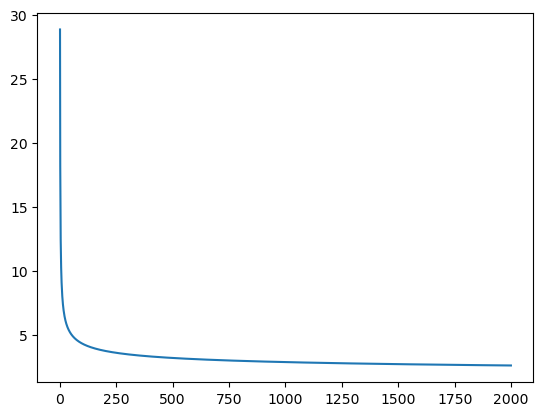

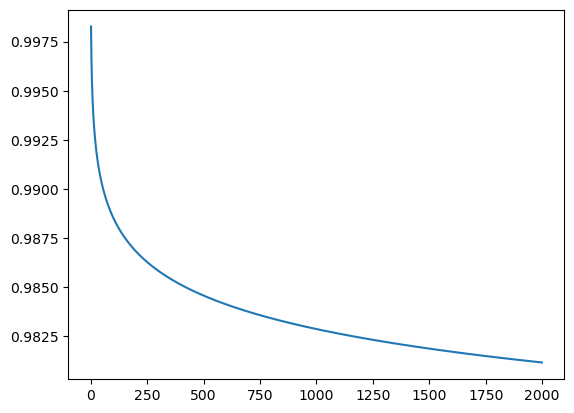

In [33]:
temperature = 20
initial_temperature = 20
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (np.log(i + 1))
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))
plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

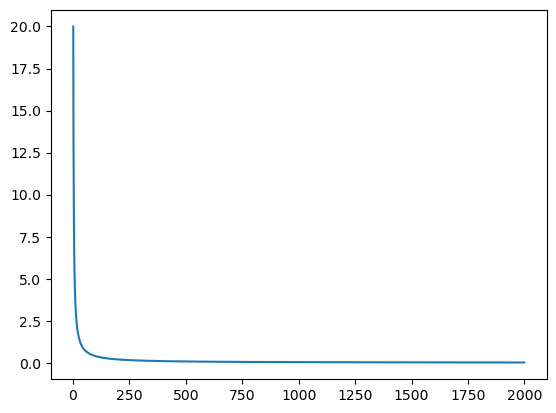

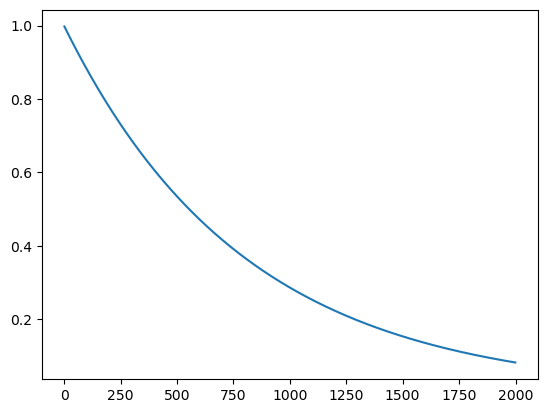

In [34]:
temperature = 20
initial_temperature = 40
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (1 + i)
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))

plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

## 2. Test Runs: TSP - Configuration: EIL51

In [31]:
os.getcwd()

'/Users/aleksandar/Documents/GitHub/simulated_annealing'

2.1 Set up the file extraction

In [32]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'eil51.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

2.2 Run the default simulated annealing simulation

2.2.1 Initialization with a fixed cooling rate

In [ ]:
tsp_file_path = file_path
cities = read_tsp_file(tsp_file_path)
random.shuffle(cities)
    
initial_temp = 1400
cooling_rate = 0.995 

2.2.2 Estimate the best tour route and distance 

33964.44949870463
33821.967559771154
33775.5835351751
33568.54363967839
33494.73075979855
33472.53062105097
33262.37774674852
33203.58820653026
33020.83943464113
32887.612168804335
32823.48595460672
32726.915058181206
32591.84833667268
32589.909665991898
32576.741747898806
32408.21078409243
32242.0287772287
32065.340355115008
31986.575306986433
31767.741175687435
31628.10092640448
31609.176600997747
31524.665619026397
31518.383932063967
31516.907681274657
31514.951780495074
31465.892961414625
31436.75593771181
31290.61527958313
31251.357868083363
31216.00290579574
31141.116231489494
31037.655278937076
30977.056859068427
30913.01512582928
30855.033824595328
30801.53922981316
30729.319011327734
30559.652236062535
30415.3088129126
30397.859412426038
30386.50335622104
30355.859067576075
30278.348141470877
30187.7703215425
30104.21735769895
30088.3095637519
30067.840458807445
29928.591605226393
29865.44819814572
29769.673267310867
29743.954895884395
29688.536834559924
29685.14117318569
2965

11621.379124344188
11613.950057649048
11598.556651356344
11589.8360874884
11581.664223180438
11574.682798360847
11567.102300185054
11553.58593093965
11520.766237663416
11505.056319417889
11492.162056706029
11490.777953957944
11454.311869886684
11421.052730958147
11391.683332114413
11387.229521036776
11330.21076407455
11319.038375448818
11282.84240097218
11260.94098476529
11236.712548290649
11211.293646108055
11177.551893029633
11141.437448202865
11137.487669926511
11123.474446912713
11059.565405517547
11058.102010461736
11049.71451016075
11019.932259212133
10975.500268558098
10959.264889539738
10953.97282710221
10945.345452780062
10934.163029076783
10903.860688847313
10888.988212044873
10866.83326942203
10861.23917720339
10771.526570736967
10764.824792018315
10755.286829204117
10754.770274280467
10748.479009735513
10734.08389798592
10696.262414488518
10655.46386596771
10652.37318439222
10624.962655180145
10614.781227742758
10589.266872712149
10588.324120074285
10540.91361737789
10529.6

5360.285330106511
5349.0199780088205
5342.392561010851
5334.5028284075515
5331.401077724037
5324.94951779193
5320.845000426568
5320.094977302286
5313.522616548318
5297.700398272543
5297.174253363187
5296.218552568779
5289.40051791207
5271.708727388742
5255.708727388742
5238.385799817465
5233.541389613753
5223.652845793755
5213.324397172264
5208.209482559312
5194.839423556773
5185.189450379007
5170.614615057993
5162.605772077457
5162.211041283092
5162.151275863236
5150.390318218606
5139.076609719621
5127.844920348636
5119.342533171375
5105.803250182966
4994.256238433002
4964.27172565064
4956.28765067225
4948.9305548878565
4948.353962300332
4939.462458903203
4938.5165943488455
4934.772783136069
4931.708322313275
4925.961705526484
4922.52105362986
4915.672046141781
4890.531943563132
4870.059615006329
4868.634450327343
4862.880943747565
4853.5575002992155
4850.536861368839
4840.64831754884
4832.689643887853
4827.413029848187
4819.360448171231
4814.158195852247
4766.045416845281
4763.246094

2817.910608576919
2812.826534449393
2809.512825950408
2806.251699128379
2804.5853789698963
2799.6065467488497
2795.371469412249
2793.9470276169304
2793.014010963946
2792.122507566817
2791.887617066131
2791.6280954132635
2789.739551593265
2789.5456825947203
2788.1205179157337
2787.9792521235017
2787.229014518605
2785.341690765807
2784.450187368678
2783.2830030986756
2783.148248027442
2781.5357250709094
2778.8005381200164
2770.8005381200164
2770.256919314348
2769.830323880718
2765.686194455409
2764.8393072578383
2764.5106831880603
2755.17646444619
2753.7512997672034
2750.838057536635
2749.946554139506
2748.2541228145365
2748.060253815992
2747.526592534134
2746.6350891370053
2744.6856444036234
2741.879395928758
2740.454231249772
2735.2519789307885
2733.8268142518023
2727.1993972538326
2727.1993972538316
2723.770194205296
2720.456485706311
2715.951867785912
2713.529662684056
2712.939340145405
2711.0507963254063
2708.6285912235503
2707.203426544564
2706.6433893209337
2704.754845500935
2701.

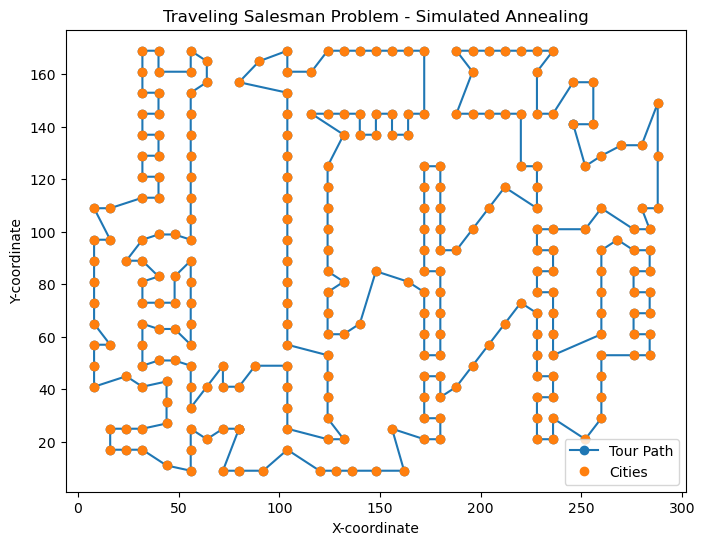

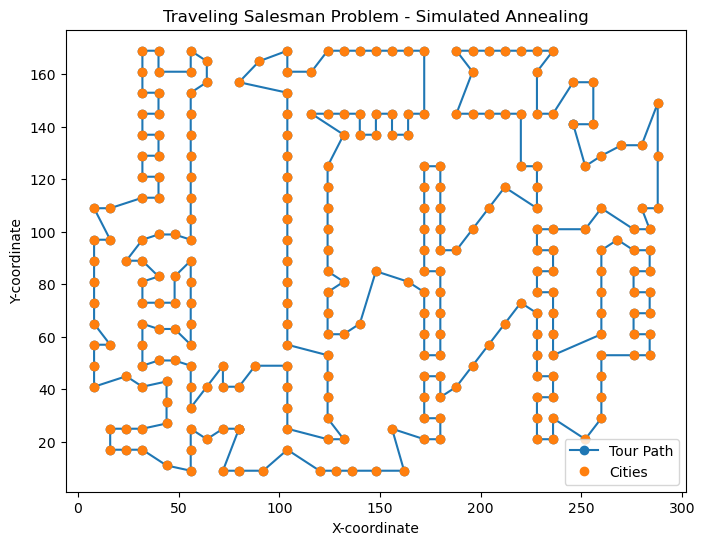

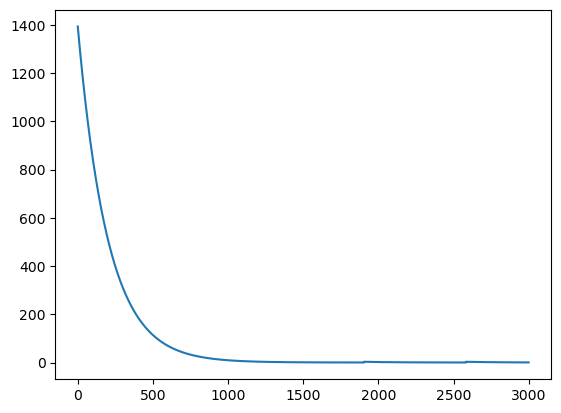

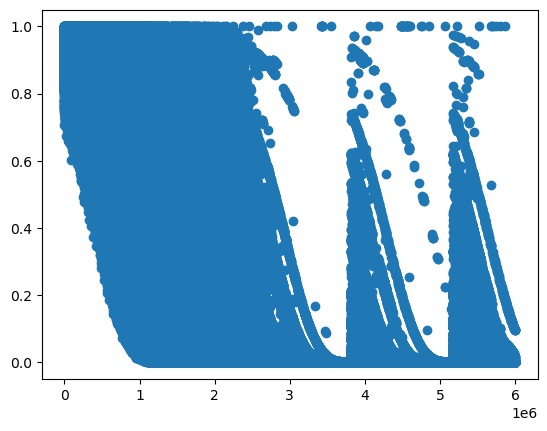

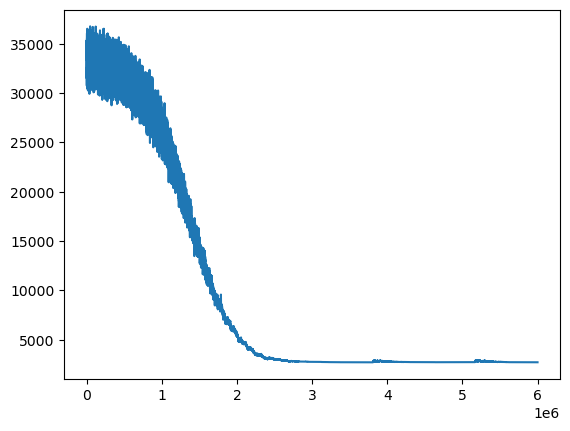

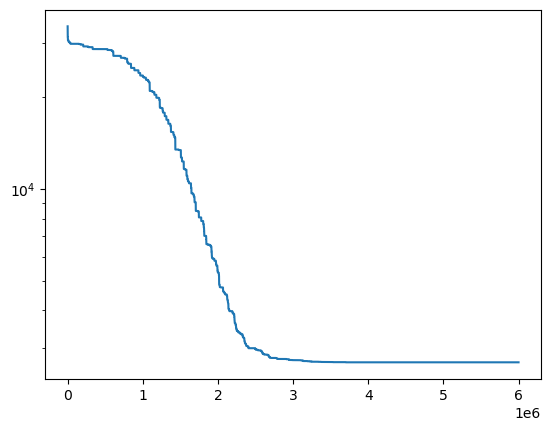

In [30]:
best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities,initial_temp,cooling_rate )
best_distance = calculate_total_distance(best_tour, cities)

2.2.3 Apply further optimization options on the best_tour

In [ ]:
best_route_2opt = optimise_with_2opt(best_tour, cities)
best_dist_2opt = calculate_total_distance(best_route_2opt, cities)

In [ ]:
print(abs_best)

2.2.4. Run the simulated annealing method with the 2-opt and move-city corrections

In [ ]:
best_tour, best_distance = simulated_annealing_tomc(cities)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

2.2.5. Run multiple simulations of simulated annealing method with the 2-opt and move-city corrections

In [ ]:
best_tour, best_distance = run_multiple_simulations(cities, num_simulations=100)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

In [ ]:
tor = [1,
2,
242,
243,
244,
241,
240,
239,
238,
237,
236,
235,
234,
233,
232,
231,
246,
245,
247,
250,
251,
230,
229,
228,
227,
226,
225,
224,
223,
222,
221,
220,
219,
218,
217,
216,
215,
214,
213,
212,
211,
210,
207,
206,
205,
204,
203,
202,
201,
198,
197,
196,
195,
194,
193,
192,
191,
190,
189,
188,
187,
186,
185,
184,
183,
182,
181,
176,
180,
179,
150,
178,
177,
151,
152,
156,
153,
155,
154,
129,
130,
131,
20,
21,
128,
127,
126,
125,
124,
123,
122,
121,
120,
119,
157,
158,
159,
160,
175,
161,
162,
163,
164,
165,
166,
167,
168,
169,
170,
172,
171,
173,
174,
107,
106,
105,
104,
103,
102,
101,
100,
99,
98,
97,
96,
95,
94,
93,
92,
91,
90,
89,
109,
108,
110,
111,
112,
88,
87,
113,
114,
115,
117,
116,
86,
85,
84,
83,
82,
81,
80,
79,
78,
77,
76,
75,
74,
73,
72,
71,
70,
69,
68,
67,
66,
65,
64,
58,
57,
56,
55,
54,
53,
52,
51,
50,
49,
48,
47,
46,
45,
44,
59,
63,
62,
118,
61,
60,
43,
42,
41,
40,
39,
38,
37,
36,
35,
34,
33,
32,
31,
30,
29,
28,
27,
26,
22,
25,
23,
24,
14,
15,
13,
12,
11,
10,
9,
8,
7,
6,
5,
4,
277,
276,
275,
274,
273,
272,
271,
16,
17,
18,
19,
132,
133,
134,
270,
269,
135,
136,
268,
267,
137,
138,
139,
149,
148,
147,
146,
145,
199,
200,
144,
143,
142,
141,
140,
266,
265,
264,
263,
262,
261,
260,
259,
258,
257,
254,
253,
208,
209,
252,
255,
256,
249,
248,
278,
279,
3,
280
]